# CT 복원영상에서 폐, 기도, 심장을 가이드해주는 딥러닝 모델 만들기

## 1. CT이미지 데이터셋 살펴보기

In [1]:
import os
import pandas as pd

In [2]:
data_dir = "../../cv-project/MEDICAL/MEDICAL-DATASET-001/Segmentation/"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [3]:
def extract_client_id(x):
    return x.split("_")[0]

In [4]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_client_id(x))
data_df

,ImageId,MaskId,Id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [5]:
import numpy as np

In [6]:
print(np.version.version)

1.24.3


In [7]:
client_ids = np.unique(data_df.Id.values)
print(len(client_ids))

112


In [8]:
index = 0
client_data = data_df[data_df.Id == client_ids[index]][["ImageId", "MaskId"]]

In [9]:
import cv2
import matplotlib.pyplot as plt

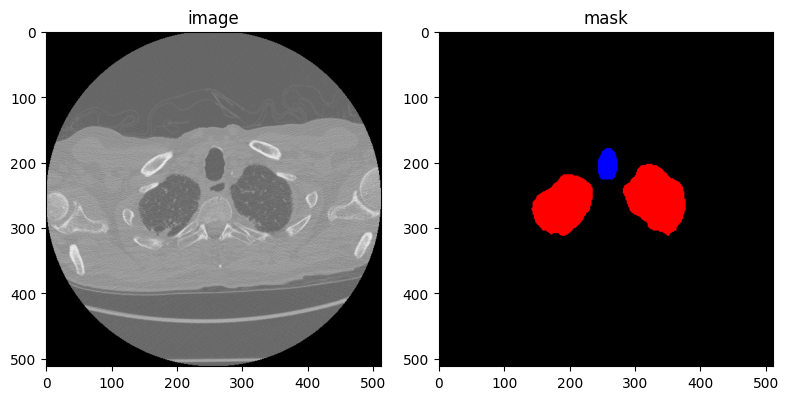

In [52]:
sub_index = 3
img_name, mask_name = client_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [53]:
def get_client_data(data_df, index):
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[index]
    client_data = data_df[data_df.Id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [54]:
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255))

In [51]:
index = 0
client_id, image_files, mask_files = get_client_data(data_df, index)

canvas = np.zeros(shape=(512, 2*512+50, 3), dtype=np.uint8)
for i in range(len(image_files)):
    image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255
    grid_pad = 50
    
    canvas[:, :512, :] = image
    canvas[:, 512+grid_pad:2*512+grid_pad, :] = mask
    
    text_buff = 410
    for j in range(1, len(regions)):
        cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40
    
    cv2.imshow('CT frames', canvas)
    key = cv2.waitKey(60)
    if key == 27:
        break
cv2.destroyAllWindows()

## 2. 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [14]:
import torch

In [15]:
class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]
        assert len(self.image_files) == len(self.mask_files)
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255
        
        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[...,0] != 0] = 0
        background[mask[...,1] != 0] = 0
        background[mask[...,2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False)
        
        if self.transformer:
            image = self.transformer(image)
        target = torch.from_numpy(mask).long()
        return image, target

In [16]:
IMAGE_SIZE = 224

In [17]:
from torchvision import transforms

In [18]:
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformer

In [19]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch: 
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0) 
    targets = torch.stack(targets, dim=0)

    return images, targets

In [20]:
from torch.utils.data import DataLoader

In [21]:
data_dir = "../../cv-project/MEDICAL/MEDICAL-DATASET-001/Segmentation/"
transformer = build_transformer()
tr_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [22]:
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()
    
    dataloaders = {}
    train_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [23]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"masks shape: {targets.shape}")
    if index == 0:
        break

images shape: torch.Size([4, 3, 224, 224])
masks shape: torch.Size([4, 224, 224])


## 3. U-Net 데이터 아키텍처 구현해보기

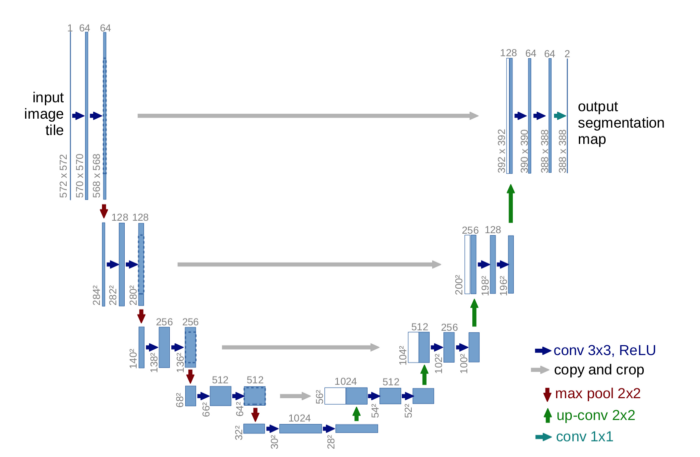
그림 출처: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

In [24]:
import torch
import torch.nn as nn

In [25]:
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [26]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        encode_features = []
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block5(out)
        return out, encode_features

In [27]:
encoder = Encoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)

In [28]:
for ftr in ftrs:
    print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [29]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [30]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)
        
        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)
        
        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)
        
        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)
        
    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)
        
        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)
        
        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)
        
        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out
        
    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [31]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [32]:
print(out.shape)

torch.Size([1, 64, 224, 224])


In [33]:
import torch.nn.functional as F

In [34]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim
        
    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [35]:
model = UNet(num_classes=4)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 4, 224, 224])


## 4. Dice similarity coefficient 설명 및 구현하기

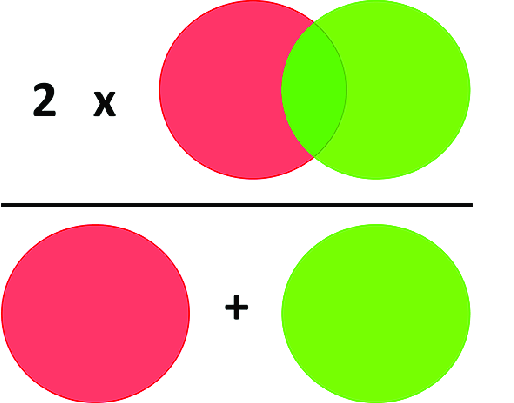
그림 출처: https://www.researchgate.net/figure/Scheme-to-explain-how-Dice-coefficient-is-calculated-The-light-red-and-light-green_fig4_352895635

### Dice similarity coefficient(DSC) == F1 score? YES only if binary segmentation task!

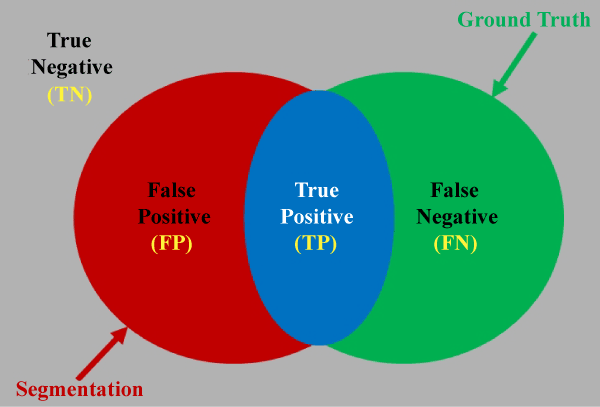
그림 출처: https://www.omicsonline.org/articles-images/JCSB-07-209-g003.html

### What is Dice coefficient loss or Dice loss? Dice loss = 1 - DSC

In [36]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    
    if index == 0:
        break

In [37]:
num_classes = 4

predictions_ = torch.argmax(predictions, dim=1)
onehot_pred = F.one_hot(predictions_, num_classes=num_classes).permute(0, 3, 1, 2)
onehot_target = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)

In [38]:
onehot_pred_ = onehot_pred[0]
onehot_target_ = onehot_target[0]

dice_coeff = 0
for class_index in range(1, num_classes):
    a = onehot_pred_[class_index]
    b = onehot_target_[class_index]
    set_inter = torch.dot(a.reshape(-1).float(), b.reshape(-1).float())
    set_sum = a.sum() + b.sum()
    dice_coeff += (2 * set_inter) / (set_sum + 1e-9)
dice_coeff /= (num_classes-1)

In [39]:
dice_loss = 1. - dice_coeff

In [40]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        
    def __call__(self, pred, target):
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        dice_loss = self._get_dice_loss(onehot_pred, onehot_target)
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return dice_loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [41]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)

(tensor(0.9416), tensor(0.0584))

## 5. Loss function 구현 및 SGDM 최적화 적용하기

In [42]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")
        
    def __call__(self, pred, target):
        loss1 = self.CE_loss(pred, target)
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)
        loss = loss1 + loss2
        
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [43]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)

(tensor(2.4520, grad_fn=<AddBackward0>), tensor(0.0584))

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [45]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    criterion(predictions, targets)
    if index == 1:
        break

## 6. Semantic segmentation 학습을 위한 코드 작성하기

In [46]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
    losses = {}
    dice_coefficients = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_dice_coeff = 0.0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)
            
            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                loss, dice_coefficient = criterion(predictions, targets)
                
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()
            running_dice_coeff += dice_coefficient.item()
            
            if phase == "train":
                if index % 100 == 0:
                    text = f"{index}/{len(dataloaders[phase])}" + \
                            f" - Running Loss: {loss.item():.4f}" + \
                            f" - Running Dice: {dice_coefficient.item():.4f}" 
                    print(text)

        losses[phase] = running_loss / len(dataloaders[phase])
        dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
    return losses, dice_coefficients

In [47]:
from utils import save_model

In [48]:
data_dir = "../../cv-project/MEDICAL/MEDICAL-DATASET-001/Segmentation/"
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
# BATCH_SIZE = 2
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [49]:
print(DEVICE)

cuda


In [ ]:
num_epochs = 10

best_epoch = 0
best_score = 0.0
train_loss, train_dice_coefficient = [], []
val_loss, val_dice_coefficient = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_dice_coefficient.append(dice_coefficients["train"])
    val_dice_coefficient.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")
    
    if (epoch > 3) and (dice_coefficients["val"] > best_score):
        best_epoch = epoch
        best_score = dice_coefficients["val"]
        save_model(model.state_dict(), f"model_{epoch:02d}.pth")
        
print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_dice_coefficient, label="train")
plt.plot(val_dice_coefficient, label="val")
plt.xlabel("epoch")
plt.ylabel("dice coefficient")
plt.grid("on")
plt.legend()
plt.tight_layout()

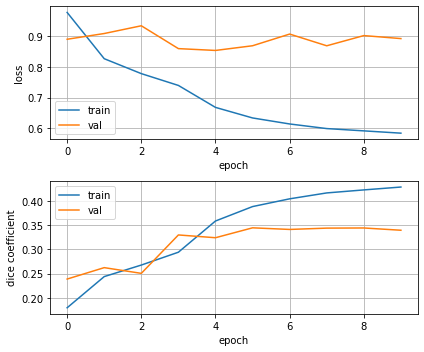

## 7. 모델 테스트 및 Morphological filtering 적용하기

In [ ]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [ ]:
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

In [ ]:
ckpt_path = "./trained_model/model_05.pth"
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
def morpholocal_process(mask, num_classes, ksize=7):
    new_mask = mask.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(ksize, ksize))

    for class_index in range(1, num_classes):
        binary_mask = (mask == class_index).astype(np.uint8)
        closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        new_mask[closing.astype(np.bool_)] = class_index
    return new_mask

In [ ]:
from utils import CLASS_ID_TO_RGB

In [ ]:
def decode_segmap(mask, num_classes):
    mask_H, mask_W = mask.shape
    R_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    G_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    B_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)

    for class_index in range(1, num_classes):
        R_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][0]
        G_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][1]
        B_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][2]
    
    RGB_mask = cv2.merge((B_channel, G_channel, R_channel))
    return RGB_mask

In [ ]:
from PIL import Image

In [ ]:
@torch.no_grad()
def predict_segment(image, model, num_classes, device):
    PIL_image = Image.fromarray(image)
    tensor_image = transformer(PIL_image)
    tensor_image = tensor_image.to(device)

    pred_mask = model(torch.unsqueeze(tensor_image, dim=0))
    pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0)
    pred_mask = pred_mask.numpy()
    pred_mask = morpholocal_process(pred_mask, num_classes)
    rgb_mask = decode_segmap(pred_mask, num_classes)
    return rgb_mask

In [ ]:
video_path = "../DATASET/Segmentation/video/test/ID00411637202309374271828.mp4"
cnt = 0
vidcap = cv2.VideoCapture(video_path)
while (vidcap.isOpened()):
    ret, frame = vidcap.read()

    if ret:
        rgb_mask = predict_segment(frame, model, NUM_CLASSES, DEVICE)
        rgb_mask = cv2.resize(rgb_mask, dsize=frame.shape[:2])
              
        alpha = 0.6
        blend = cv2.addWeighted(frame, alpha, rgb_mask, 1-alpha, 0)
        cv2.imshow('output', blend)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey(0)
    else:
        break
        
vidcap.release()
cv2.destroyAllWindows()
#왜 커밋 안돼